# Semi-supervised VAE on CIFAR-100 

This notebook contains experiments with semi-supervised VAE on CIFAR-100 data.

reference paper: https://arxiv.org/abs/1406.5298

** Requirements **

This notebook has been implemented using:

- Python 3.7.7
- Numpy 1.18.1
- Pandas 1.0.3
- Scipy 1.4.1
- PyTorch 1.4.0
- torchvision 0.5.0
- Scikit-Learn 0.22.1
- matplotlib 3.1.3
- seaborn 0.10.0

**Install Requirements** (Uncomment if not installed)

In [34]:
# !pip install \
# numpy==1.18.1 \
# pandas==1.0.3 \
# scipy==1.4.1 \
# torch==1.4.0 \
# torchvision==0.5.0 \
# scikit-learn==0.22.2.post1 \
# matplotlib==3.2.1 \
# seaborn==0.10.0

### Imports

In [36]:
# Python lib
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import random
from typing import List, Tuple, Optional
import types
import itertools

# Scientific utilities
import numpy as np
import pandas as pd
from scipy.stats import norm as ndist
from sklearn.metrics import confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.utils import make_grid

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Globals

In [37]:
DATA_DIR = 'data' # relative path to download and store data

BATCH_SIZE = 100

LABELED_DATA_SIZE = 0.05 # in percents

N_CLASSES = 100

** Fixing random seed for reproducibility **

In [38]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

### Preparing Data

Conveniently, PyTorch comes with pre-defined MNIST dataset so we are going to use it directly.

In [39]:
def get_cifar100_ds(train: bool):
    
    seed_everything()

    ds = torchvision.datasets.CIFAR100(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))]),
                                      target_transform=None, 
                                      download=True)

    
    if not train:
        return ds
    
    # making sure that labeled portion of data has equal number of classes (thus making P(Y) uniform prior).
    
    sz = int(LABELED_DATA_SIZE * len(ds) / N_CLASSES)
    cnt = [0] * N_CLASSES
    indices_l = []
    indices_u = []
    
    labels = list(zip(torch.LongTensor(ds.targets).tolist(), range(len(ds))))
    np.random.shuffle(labels) # shuffling data, just in case 
    
    for i in range(len(ds)):
        y, idx = labels[i]
        if cnt[y] != sz:
            cnt[y] += 1
            indices_l.append(idx)
        else:
            indices_u.append(idx)
        
    # making sure we partition the whole data into disjoint labelled/unlabelled subsets correctly.
    assert sorted(indices_l + indices_u) == list(range(len(ds)))
    
    # making sure we can distribute all of the data into equally-sized batches without leftover.
    assert len(indices_l) % BATCH_SIZE == 0
    assert len(indices_u) % BATCH_SIZE == 0
    
    return Subset(ds, indices_l), Subset(ds, indices_u)


In [40]:
def get_cifar100_dls():
    """Returns separate DataLoaders per labelled/unlabelled and validation sets."""
    
    train_ds, train_ds_u = get_cifar100_ds(train=True)
    
    valid_ds = get_cifar100_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False, 
                                        drop_last=True),
            
            torch.utils.data.DataLoader(train_ds_u, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True, 
                                        pin_memory=False, 
                                        drop_last=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=False, 
                                        drop_last=False))

train_dl, train_dl_u, valid_dl = get_cifar100_dls()

print("Number of labelled, unlabelled and valid samples: ", len(train_dl.dataset), 
                                                            len(train_dl_u.dataset), 
                                                            len(valid_dl.dataset)) 
      
print("Number of labelled, unlabelled and valid batches: ", len(train_dl), 
                                                            len(train_dl_u), 
                                                            len(valid_dl))

100.0%

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Number of labelled, unlabelled and valid samples:  2500 47500 10000
Number of labelled, unlabelled and valid batches:  25 475 50


**Showing a few samples from the dataset**


Batch Statistics:
 shape: torch.Size([100, 3, 32, 32]), mean: -0.024565445259213448, std: 0.9842115044593811, min: -1.8974260091781616, max: 2.0242578983306885


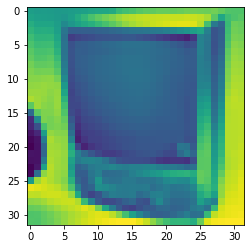

Batch Statistics:
 shape: torch.Size([100, 3, 32, 32]), mean: 0.06418927013874054, std: 1.0062391757965088, min: -1.8974260091781616, max: 2.0242578983306885


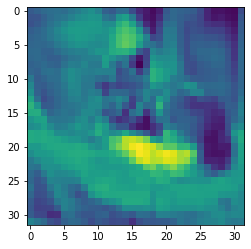

Batch Statistics:
 shape: torch.Size([100, 3, 32, 32]), mean: 0.027413101866841316, std: 0.9674651622772217, min: -1.8974260091781616, max: 2.0242578983306885


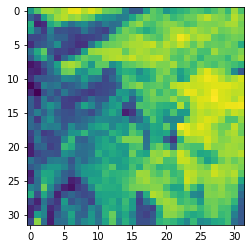

In [49]:
for i, (x, y) in enumerate(train_dl):
    print(f"Batch Statistics:\n shape: {x.shape}, mean: {x.mean()}, std: {x.std()}, min: {x.min()}, max: {x.max()}")
    plt.imshow(x[0][0])
    plt.show()
    if i > 1: break

### Defining Model Simple MLP

In [50]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.02, nonlinearity='leaky_relu')
            nn.init.constant_(m.bias, 0)

def one_hot(y, n_classes: int) -> torch.FloatTensor:
    
    assert y.ndim <= 2
    
    bs = y.shape[0]
            
    y_onehot = torch.zeros(bs, n_classes, device=y.device).long()
    y_onehot.scatter_(1, y.view(bs, 1).long(), 1)
    
    return y_onehot.float()

In [51]:
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron network."""
    
    def __init__(self, inp_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        
        self.layers = nn.Sequential(nn.Linear(inp_dim, hidden_dim),
                                    nn.LeakyReLU(0.02),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.LeakyReLU(0.02),
                                    nn.Linear(hidden_dim, out_dim))
        
        init_weights(self)
        
    def forward(self, x): 
        return self.layers(x)

In [52]:
class SSVAE(nn.Module):
    """Semi-Supervised VAE"""
    
    def __init__(self, inp_shape: Tuple[int, int, int], # (1, 28, 28) in case of MNIST
                       hidden_dim: int,
                       out_dim: int, 
                       z_dim: int, 
                       n_classes: int):
        
        super().__init__()
        
        self.inp_shape = inp_shape
        self.n_classes = n_classes
        
        inp_dim = np.prod(inp_shape) # calculating flattened input size
        
        self.enc = MLP(inp_dim + n_classes, hidden_dim, out_dim) # q(z|x,y) = Normal(z | mu, diag(sigma^2) = MLP(x, y))
        self.dec = MLP(out_dim + n_classes, hidden_dim, inp_dim) # p(x|z,y) = Bernoulli(x | p = MLP(z, y))
        
        self.cls = MLP(inp_dim, hidden_dim, n_classes) # q(y|x) = Categorical(y | p = MLP(x))
        
        self.mu     = nn.Linear(out_dim, z_dim)
        self.logvar = nn.Linear(out_dim, z_dim)
        
        self.fc = nn.Linear(z_dim, out_dim)
        
        init_weights(self)
        
    def encode(self, x, y):
        
        inp = torch.cat([torch.flatten(x, 0), one_hot(y, self.n_classes)], dim=1)
        
        enc = self.enc(inp)
        
        return self.mu(enc), self.logvar(enc)
    
    def cls_logits(self, x):
        
        return self.cls(torch.flatten(x, 0))
        
    def sample_z(self, mu, logvar):
        """Applying Gaussian reparametrization trick"""
        
        eps = torch.empty_like(mu).normal_(0, 1)
        
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z, y):

        inp = torch.cat([self.fc(z), one_hot(y, self.n_classes)], dim=1)
        
        return self.dec(inp).view(-1, *self.inp_shape)
        
    def forward(self, x, y=None):
        
        if y is None:
            y = torch.argmax(self.cls_logits(x), dim=1)
        
        mu, logvar = self.encode(x, y)
        
        z = self.sample_z(mu, logvar)
        
        return self.decode(z, y)

### Defining Loss 

In [53]:
def kl_loss(mu, logvar):
    """KL_Divergence[N(mu, logvar.exp()), N(0, 1)]"""
    
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

def loss_xy(x, x_recon, mu, logvar):
    """Returns negative ELBO(x, y) with y - class index. Eq. 6 in the paper."""
    
    bce = torch.nn.functional.binary_cross_entropy_with_logits(x_recon, x, reduction='none').sum(dim=(1, 2, 3))

    logPy = np.log(1.0 / N_CLASSES) # prior is uniform due to ballanced classes.
    
    kl = kl_loss(mu, logvar)
    
    return bce - logPy + kl

def loss_x(model: nn.Module, x, y_probs):
    "Loss for unlabelled batch. Eq. 7 in the paper."
    
    s = torch.zeros(x.shape[0], device=x.device)
    
    y_entropy = torch.distributions.Categorical(y_probs).entropy()
    
    for i in range(y_probs.shape[-1]):
        
        y = torch.empty(x.shape[0], device=x.device).fill_(i)
        
        mu, logvar = model.encode(x, y)
        
        x_recon = model.decode(model.sample_z(mu, logvar), y)
        
        s += y_probs[:, i] * loss_xy(x, x_recon, mu, logvar)
                
    return (s + y_entropy).mean()

### Training Loop

This section contains model training loop as well as some helper/visualization functions. 

In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def get_preds(valid_dl: DataLoader, model: nn.Module):
    
    model.eval()
    model.cuda()
    
    y_preds, y_trues = [], []
    with torch.no_grad():
        for x, y in valid_dl:
            
            y_pred = torch.argmax(model.cls_logits(x.cuda()), dim=1).long().tolist()
            
            y_preds.extend(y_pred)
            y_trues.extend(y.tolist())
            
    model.train()
    
    return y_trues, y_preds

In [55]:
def try_get_batch(it):
    
    x, y = None, None
    try:
        x, y = next(it)
    except StopIteration:
        pass
    
    return x, y

def get_next_batch(train_dl, train_dl_u):
    """Returns a next batch, either labelled or unlabelled, making equal gaps between alternations."""

    it_l, it_u = iter(train_dl), iter(train_dl_u)
    
    for i in range(1, 1 << 30):
        
        unlabelled = i % (len(train_dl_u) // len(train_dl)) != 0
        
        if unlabelled:
            x, y = try_get_batch(it_u)
            has_label = False
            
        if (not unlabelled) or (x is None):
            x, y = try_get_batch(it_l)
            has_label = True
        
        if x is None:
            return None, None, has_label
            
        yield x, y, has_label

In [56]:
class MetricLogger:
    """Helper class for logging metrics"""
    
    def __init__(self, name, init_val = 0):
        
        self.name = name
        self.init_val = init_val
        
        self.counter = 0
        
        self.logs = []
        
    def log(self, val):
        
        self.logs.append(val)
        
        self.counter += 1
        
    def reset(self):
        self.counter = 0
        
    @property
    def val(self):
        
        data = self.logs[len(self.logs) - self.counter:]
        
        mean, std = np.mean(data), np.std(data) 
        
        return f"Avg %s: %.5f (±%.3f)" % (self.name, mean, std)
    
    def plot(self):
        plt.title(self.name)
        plt.plot(self.logs)

In [57]:
def show_summary(valid_dl: DataLoader, model: nn.Module, acc_logger: Optional[MetricLogger] = None):
    """This is a helper function for visualizing model output quality during the training process."""
    
    N_SAMPLES = 15
    
    model.eval()
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(x)
                        
            recon_x = model(x.cuda(), torch.Tensor([y]).cuda()).sigmoid().cpu()
            
            preds.append(recon_x.view(*x.shape))
            
            if i + 1 == N_SAMPLES:
                break
                            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show() 
    
    y_trues, y_preds = get_preds(valid_dl, model)
    
    cm = confusion_matrix(y_trues, y_preds)
    
    if acc_logger:
        acc_logger.log(np.trace(cm) / float(np.sum(cm)))
    
    plot_confusion_matrix(cm, target_names=[str(i) for i in range(10)])
    
    model.train()


In [58]:
def train_vae(train_dl: DataLoader, # labelled batch dataloader
              train_dl_u: DataLoader, # unlabelled batch dataloader
              valid_dl: DataLoader, # validation set dataloader
              model: nn.Module,
              n_epochs: int,
              loss_logger: MetricLogger,
              cls_loss_logger: MetricLogger,
              acc_logger: MetricLogger,
              semi_sup_epochs: int): # number of initial epochs after which training becomes fully unsupervised
    
    LOG_INTERVAL = 20
    SUMMARY_INTERVAL = 200
    
    CLS_LOSS_WEIGHT = 0.1 * len(train_dl.dataset) # as in paper
    
    model = model.cuda()
    
    cls_crit = nn.CrossEntropyLoss()
    
    model.train()
    
    # I use default lr, weight decay, and lr annealing schedule. Fintuning can improve results...
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
    
    for epoch in range(n_epochs):
        
        for i, (x, y, has_label) in enumerate(get_next_batch(train_dl, train_dl_u)):
            
            if x is None: break
        
            optim.zero_grad()
            
            x = x.cuda()
            y = y.cuda()
            
            y_logits = model.cls_logits(x)
            
            cls_loss = cls_crit(y_logits, y)

            if has_label:
                
                # after semi_sup_epochs training becomes fully unsupervised. 
                # This allows us to see that after semi-supervised warmup, classifier is able to continue learning without labels, taking knowledge indirectly from generative process.
                # I tested this phenomenon with semi_sup_epochs=1 and z_dim=50 below...
                if epoch >= semi_sup_epochs: 
                    continue
                    
                mu, logvar = model.encode(x, y)
                
                z = model.sample_z(mu, logvar)

                x_recon = model.decode(z, y)

                loss = loss_xy(x, x_recon, mu, logvar).mean() + CLS_LOSS_WEIGHT * cls_loss
                                
            else:
                
                loss = loss_x(model, x, torch.softmax(y_logits, dim=-1))

            loss_logger.log(loss.item())
            cls_loss_logger.log(cls_loss.item())
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                
                print('epoch %d | iter %d | %s | %s' % (epoch + 1, i + 1, loss_logger.val, cls_loss_logger.val))
                
                loss_logger.reset()
                cls_loss_logger.reset()
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model, acc_logger)
            
        #lr_scheduler.step()

In [59]:
seed_everything()
vae = SSVAE(inp_shape=(3, 32, 32), hidden_dim=512, out_dim=256, z_dim=2, n_classes=100)

In [60]:
vae

SSVAE(
  (enc): MLP(
    (layers): Sequential(
      (0): Linear(in_features=3172, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.02)
      (4): Linear(in_features=512, out_features=256, bias=True)
    )
  )
  (dec): MLP(
    (layers): Sequential(
      (0): Linear(in_features=356, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.02)
      (4): Linear(in_features=512, out_features=3072, bias=True)
    )
  )
  (cls): MLP(
    (layers): Sequential(
      (0): Linear(in_features=3072, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.02)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.02)
      (4): Linear(in_features=512, out_features=100, bias=True)
    )
  )
  (mu): Line

In [61]:
loss_logger = MetricLogger("Loss")
cls_loss_logger = MetricLogger("Cls Loss")
acc_logger = MetricLogger('Accuracy')

train_vae(train_dl, train_dl_u, valid_dl, vae, 30, loss_logger, cls_loss_logger, acc_logger, semi_sup_epochs=100000)

RuntimeError: size mismatch, m1: [1 x 307200], m2: [3072 x 512] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

** Plotting Metrics **

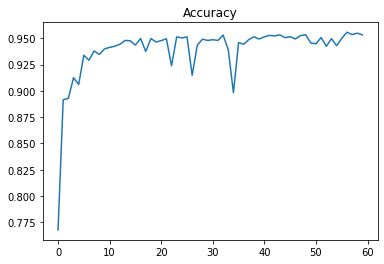

In [0]:
acc_logger.plot()

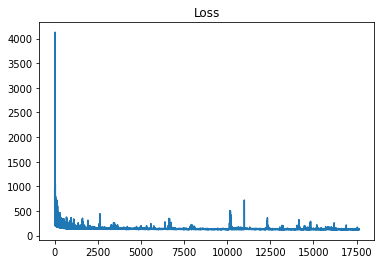

In [0]:
loss_logger.plot()

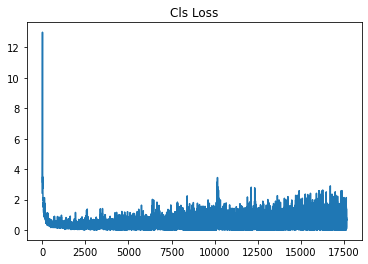

In [0]:
cls_loss_logger.plot()

### Visualizing Results

#### VIsualize 2D Latent Space (centers of Gaussian)

In [0]:
def get_df_for_viz(vae: nn.Module):

    vae.cuda()
    z, z_vars, labels = [], [], []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            mu, logvar = vae.encode(x.cuda(), y.cuda())
            mu = mu.cpu()
            var = logvar.exp().cpu()
            z.append(mu)
            labels.append(y)
            z_vars.append(var[:,0] + var[:,1])
            
    z = torch.cat(z, dim=0)
    labels = torch.cat(labels, dim=0)
    z_vars = torch.cat(z_vars, dim=0)

    df = pd.DataFrame({'x': z[:,0].numpy(), 
                       'y': z[:,1].numpy(),
                       'tot_var': z_vars.numpy(),
                       'label': labels.numpy()})

    return df

df = get_df_for_viz(vae)

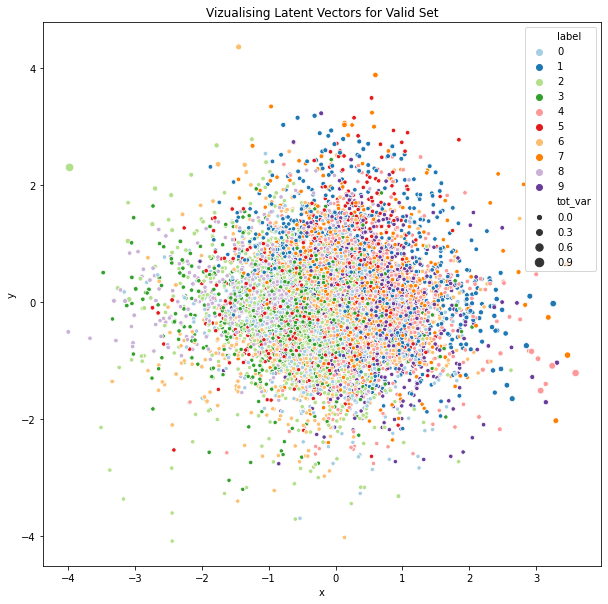

In [0]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x", y="y", hue="label", size='tot_var', palette=sns.color_palette("Paired", 10), data=df)
plt.title('Vizualising Latent Vectors for Valid Set');

In [0]:
#### Show Continuity of Latent Space

In [0]:
def draw_mnist_manifold_vae(model: nn.Module, label: int, size: int = 20):
    """This function takes a trained VAE with z_dim=2 and visualizes its latent space."""

    # generate a 2D point cloud of latent space using inverse CDF of Standard Gaussian.
    x_axes = ndist.ppf(np.linspace(0.01, 0.99, size))
    y_axes = ndist.ppf(np.linspace(0.01, 0.99, size))

    # preparing input to decoder.
    z = []
    for i, y in enumerate(x_axes):
        for j, x in enumerate(y_axes):
            z.append(torch.Tensor([x, y]))
    z = torch.stack(z)
    
    # decoding latent vectors
    preds = model.decode(z, torch.empty(z.shape[0], device=z.device).fill_(label)).detach().sigmoid()
    
    # rendering a single image from predictions.
    grid = make_grid(preds, pad_value=1, padding=1, nrow=size)[0].numpy()
    
    # showing the image.
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title('2D Latent Space')
    plt.show()

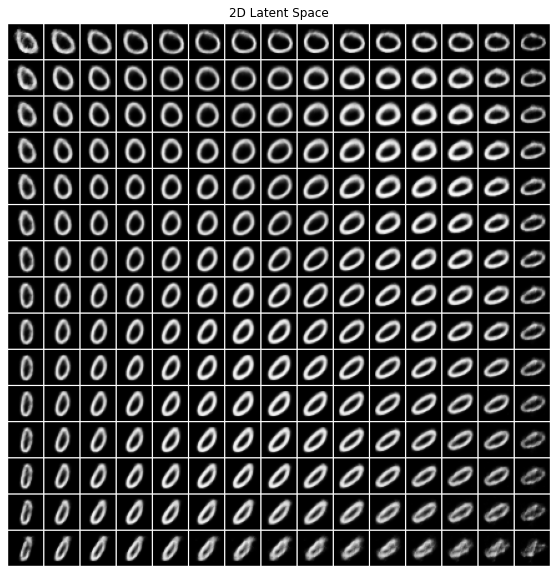

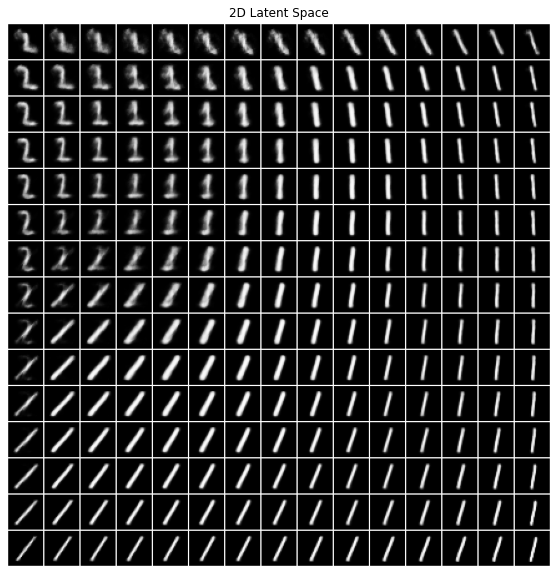

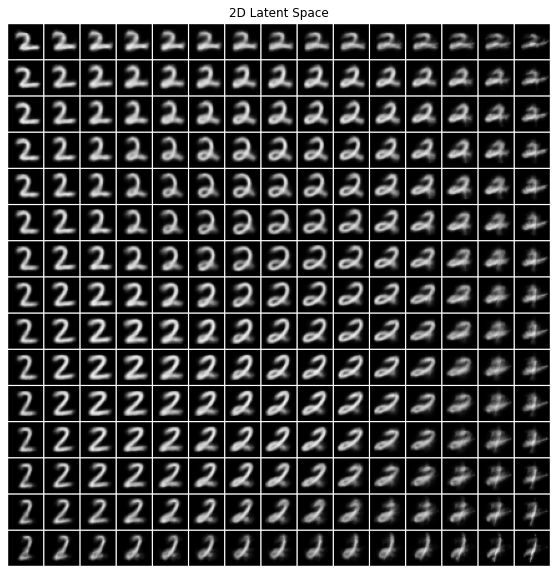

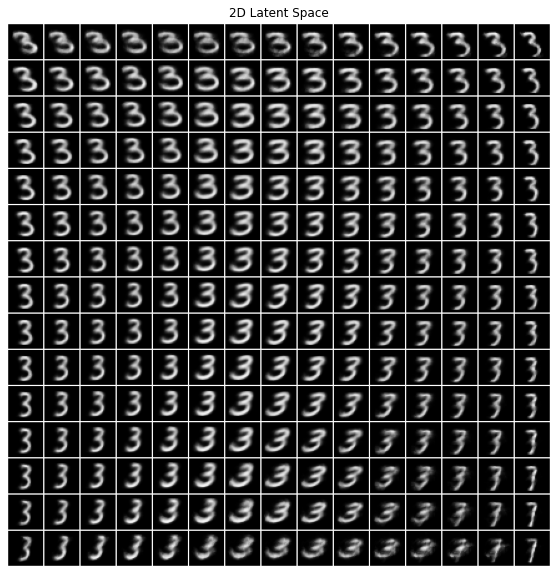

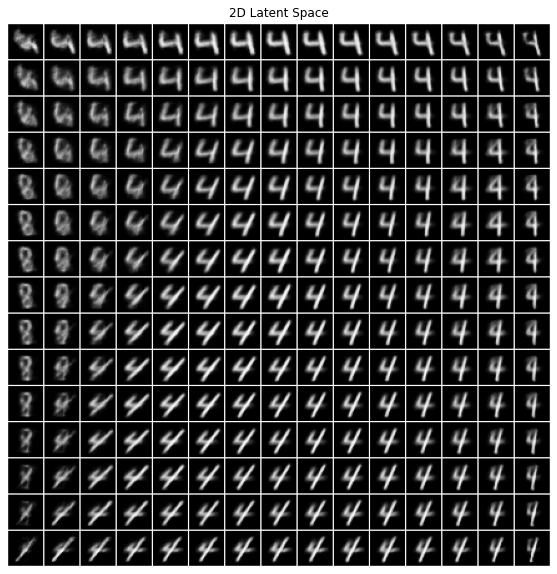

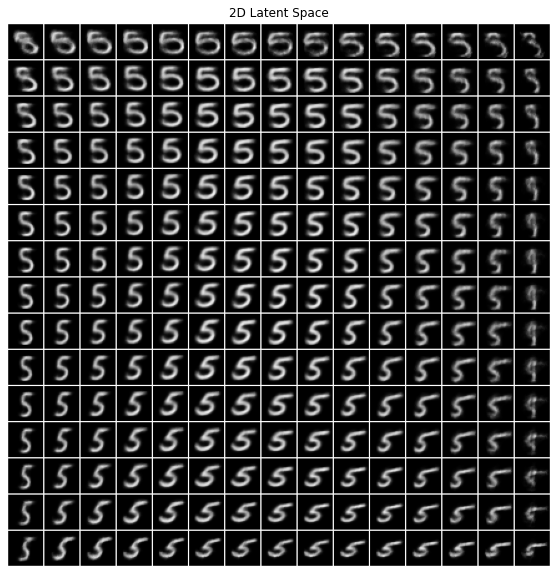

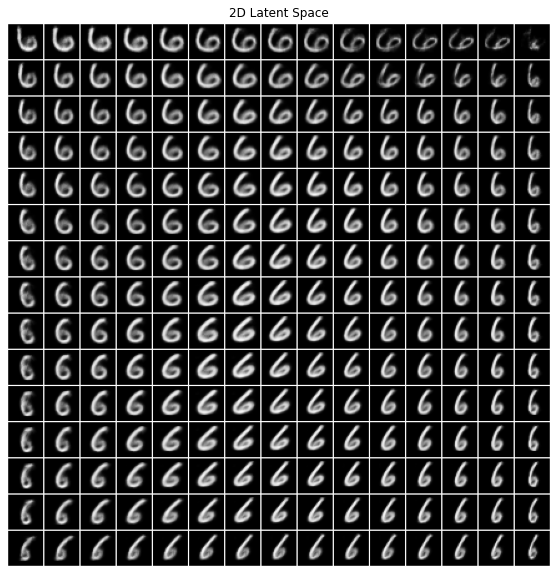

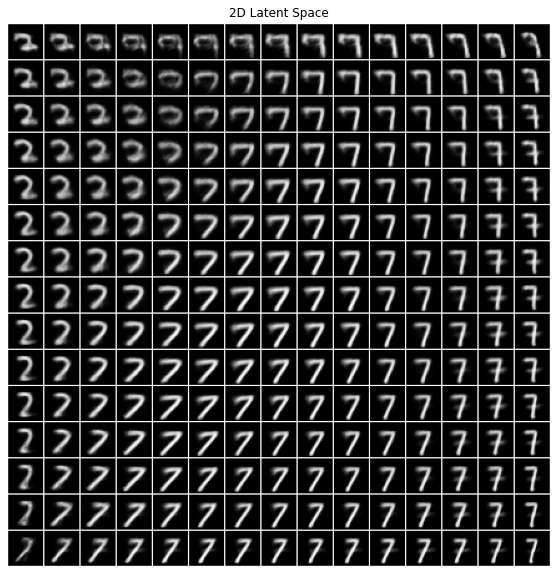

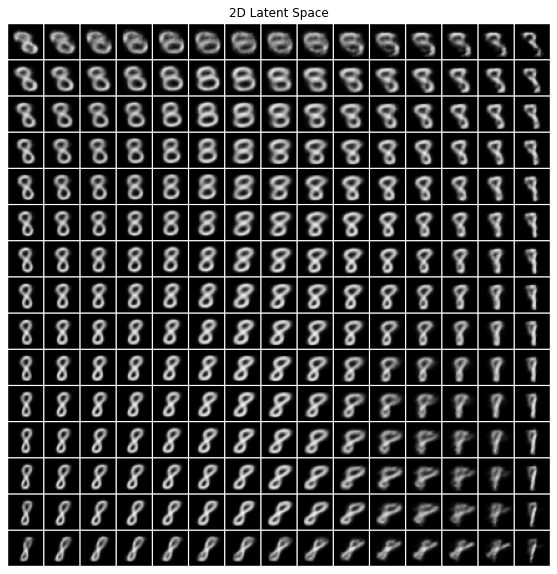

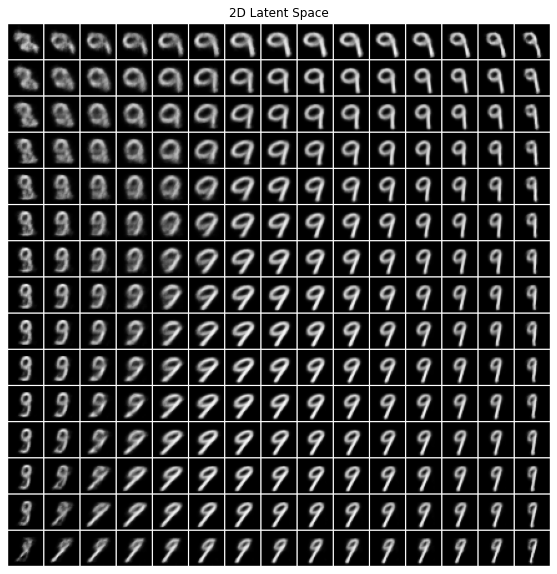

In [0]:
for label in range(10):
    draw_mnist_manifold_vae(vae.cpu(), label, size=15);

In [0]:
#### Generating Digits with Same Hadnwritting

# Here we fix Z and vary Y to generate different digits with same style.

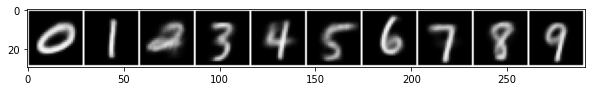

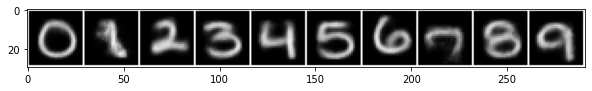

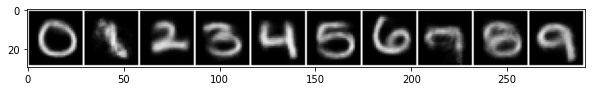

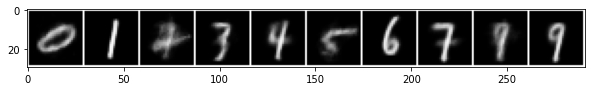

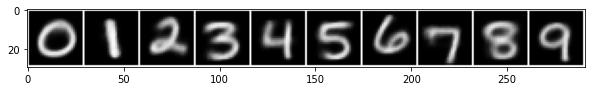

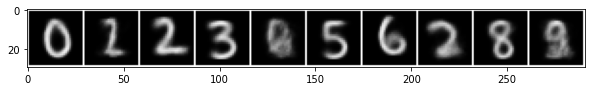

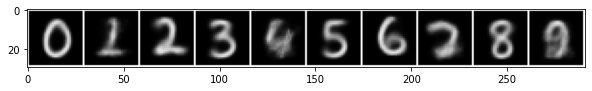

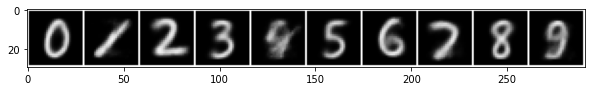

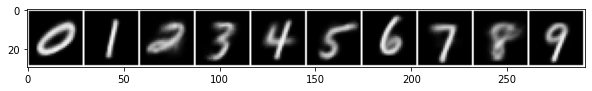

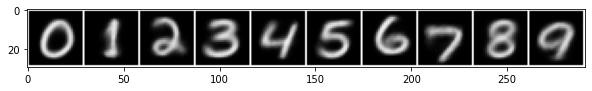

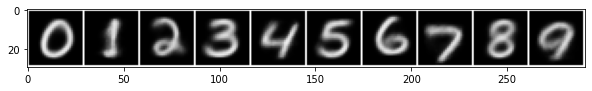

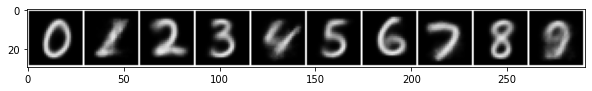

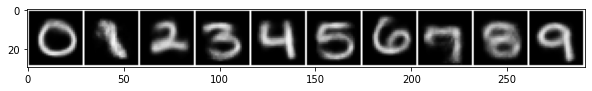

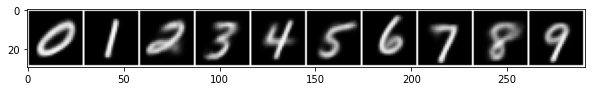

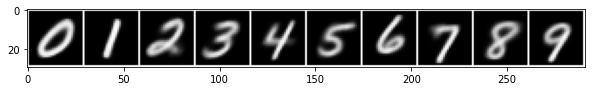

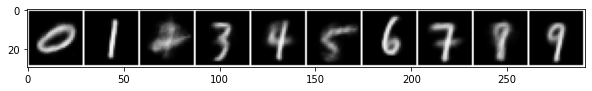

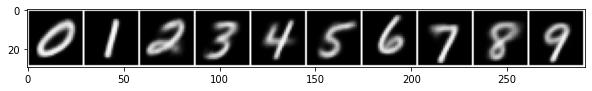

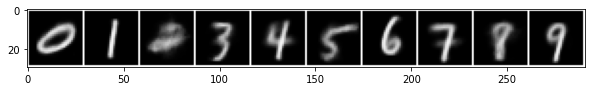

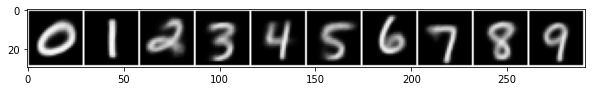

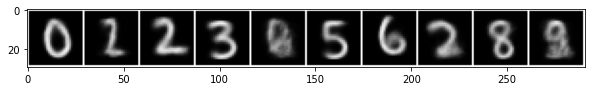

In [0]:
for i in range(20):
    z_ = torch.empty(2).normal_(0, 1).repeat(N_CLASSES, 1)

    y = torch.Tensor([i % N_CLASSES for i in range(N_CLASSES)])

    images = vae.decode(z_, y).sigmoid().detach()

    grid = make_grid(images, pad_value=1, padding=1, nrow=10)[0].detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(grid, cmap='gray');

### Unsupervised Training

In this section I show that after the first epoch (warmup) we can switch to fully-unsupervised training and classifier will still improve its score by getting indirect supervision from generative process. In other words, learning classifier and generative model jointly isn't useless.

In [0]:
seed_everything()

vae = SSVAE(inp_shape=(1, 28, 28), hidden_dim=512, out_dim=256, z_dim=50, n_classes=10)

In [0]:
# I also log gradient norm at classifier's last layer to compare signal strength in labelled VS unlabelled batch scenarios.

grad_norm = MetricLogger('grad_norm')

def record_grad_norm(self, grad_input, grad_output):
    grad_norm.log(grad_input[0].norm())

vae.cls.layers[-1].register_backward_hook(record_grad_norm)


epoch 1 | iter 20 | Avg Loss: 584.48834 (±1018.970) | Avg Cls Loss: 7.67791 (±4.366)
epoch 1 | iter 40 | Avg Loss: 269.37899 (±207.907) | Avg Cls Loss: 4.73253 (±2.194)
epoch 1 | iter 60 | Avg Loss: 237.71641 (±148.564) | Avg Cls Loss: 2.15095 (±0.148)
epoch 1 | iter 80 | Avg Loss: 212.08675 (±110.953) | Avg Cls Loss: 1.64706 (±0.137)
epoch 1 | iter 100 | Avg Loss: 194.91905 (±86.208) | Avg Cls Loss: 1.26255 (±0.090)
epoch 1 | iter 120 | Avg Loss: 186.34256 (±83.728) | Avg Cls Loss: 1.03140 (±0.134)
epoch 1 | iter 140 | Avg Loss: 183.08660 (±96.662) | Avg Cls Loss: 0.99466 (±0.174)
epoch 1 | iter 160 | Avg Loss: 181.74061 (±98.129) | Avg Cls Loss: 1.12148 (±0.192)
epoch 1 | iter 180 | Avg Loss: 169.29558 (±72.309) | Avg Cls Loss: 0.87026 (±0.152)
epoch 1 | iter 200 | Avg Loss: 167.66282 (±75.298) | Avg Cls Loss: 0.83145 (±0.208)


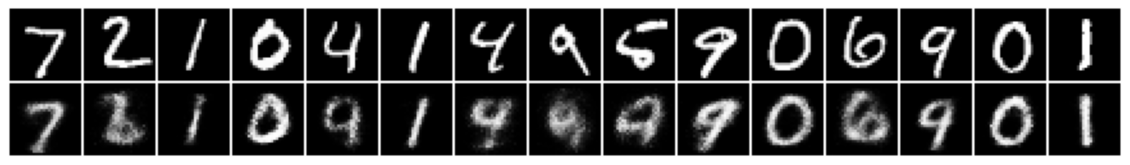

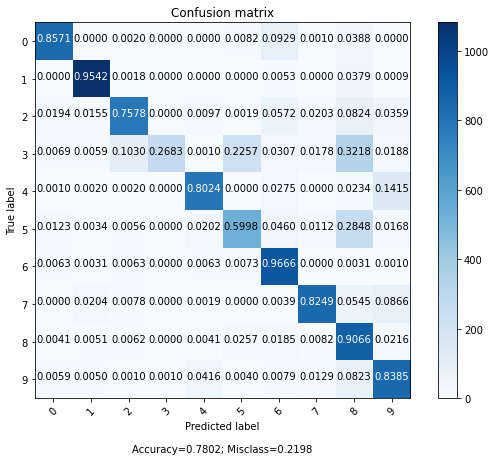

epoch 1 | iter 220 | Avg Loss: 162.86462 (±61.878) | Avg Cls Loss: 0.78518 (±0.105)
epoch 1 | iter 240 | Avg Loss: 158.06964 (±60.164) | Avg Cls Loss: 0.70477 (±0.148)
epoch 1 | iter 260 | Avg Loss: 150.66708 (±34.107) | Avg Cls Loss: 0.51427 (±0.077)
epoch 1 | iter 280 | Avg Loss: 147.04815 (±31.920) | Avg Cls Loss: 0.47931 (±0.090)
epoch 1 | iter 300 | Avg Loss: 145.22982 (±32.170) | Avg Cls Loss: 0.52560 (±0.148)
epoch 1 | iter 320 | Avg Loss: 149.69614 (±64.438) | Avg Cls Loss: 0.66122 (±0.176)
epoch 1 | iter 340 | Avg Loss: 152.75082 (±72.689) | Avg Cls Loss: 0.69927 (±0.176)
epoch 1 | iter 360 | Avg Loss: 144.61403 (±51.940) | Avg Cls Loss: 0.51575 (±0.091)
epoch 1 | iter 380 | Avg Loss: 156.06963 (±67.855) | Avg Cls Loss: 0.48160 (±0.121)
epoch 1 | iter 400 | Avg Loss: 144.81131 (±59.846) | Avg Cls Loss: 0.48187 (±0.137)


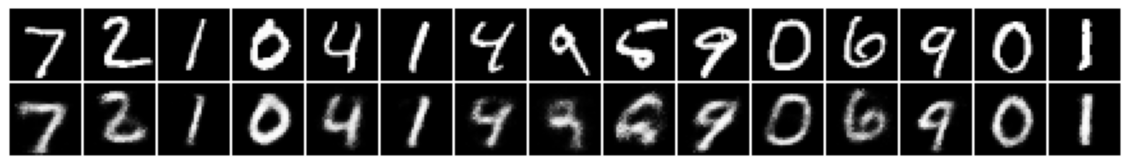

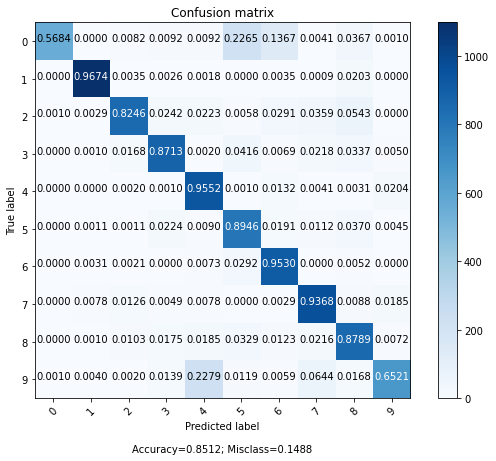

epoch 1 | iter 420 | Avg Loss: 138.97313 (±43.520) | Avg Cls Loss: 0.60643 (±0.150)
epoch 1 | iter 440 | Avg Loss: 140.74814 (±48.798) | Avg Cls Loss: 0.53056 (±0.123)
epoch 1 | iter 460 | Avg Loss: 137.67370 (±35.946) | Avg Cls Loss: 0.49031 (±0.084)
epoch 1 | iter 480 | Avg Loss: 133.27630 (±20.975) | Avg Cls Loss: 0.45419 (±0.106)
epoch 1 | iter 500 | Avg Loss: 132.41654 (±28.691) | Avg Cls Loss: 0.34961 (±0.088)
epoch 1 | iter 520 | Avg Loss: 129.05251 (±15.839) | Avg Cls Loss: 0.35848 (±0.111)
epoch 1 | iter 540 | Avg Loss: 132.33033 (±32.544) | Avg Cls Loss: 0.39570 (±0.098)
epoch 1 | iter 560 | Avg Loss: 130.13738 (±23.800) | Avg Cls Loss: 0.36266 (±0.067)
epoch 1 | iter 580 | Avg Loss: 129.79510 (±23.664) | Avg Cls Loss: 0.40570 (±0.093)
epoch 2 | iter 20 | Avg Loss: 123.30069 (±3.159) | Avg Cls Loss: 0.40768 (±0.111)
epoch 2 | iter 40 | Avg Loss: 123.31516 (±3.679) | Avg Cls Loss: 0.43028 (±0.108)
epoch 2 | iter 60 | Avg Loss: 122.23834 (±3.561) | Avg Cls Loss: 0.41202 (±0.105

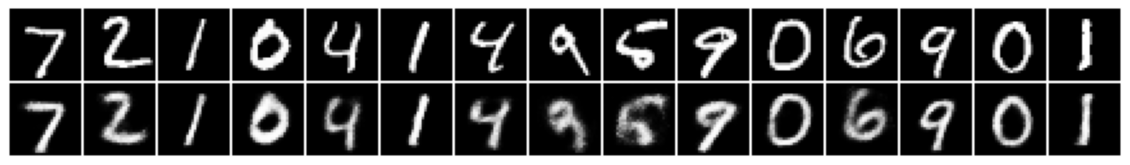

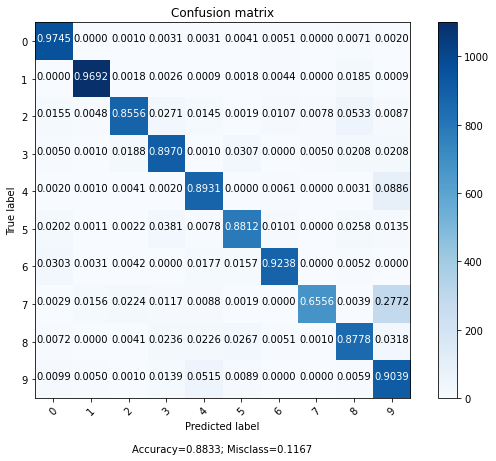

epoch 2 | iter 220 | Avg Loss: 119.72165 (±2.984) | Avg Cls Loss: 0.36173 (±0.100)
epoch 2 | iter 240 | Avg Loss: 119.37910 (±3.378) | Avg Cls Loss: 0.36995 (±0.072)
epoch 2 | iter 260 | Avg Loss: 118.51164 (±2.941) | Avg Cls Loss: 0.32637 (±0.079)
epoch 2 | iter 280 | Avg Loss: 120.23093 (±3.614) | Avg Cls Loss: 0.39943 (±0.106)
epoch 2 | iter 300 | Avg Loss: 119.16863 (±3.937) | Avg Cls Loss: 0.35137 (±0.079)
epoch 2 | iter 320 | Avg Loss: 117.29269 (±2.805) | Avg Cls Loss: 0.32810 (±0.094)
epoch 2 | iter 340 | Avg Loss: 118.13673 (±3.391) | Avg Cls Loss: 0.34121 (±0.077)
epoch 2 | iter 360 | Avg Loss: 118.37283 (±3.349) | Avg Cls Loss: 0.32584 (±0.066)
epoch 2 | iter 400 | Avg Loss: 116.55478 (±3.362) | Avg Cls Loss: 0.36322 (±0.089)


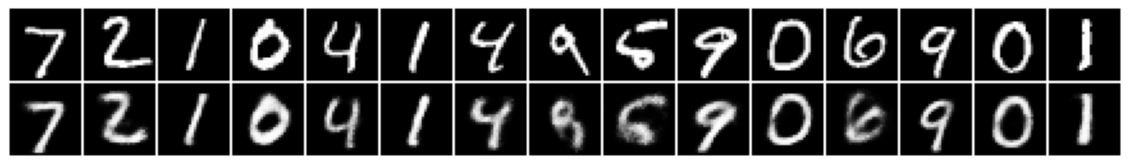

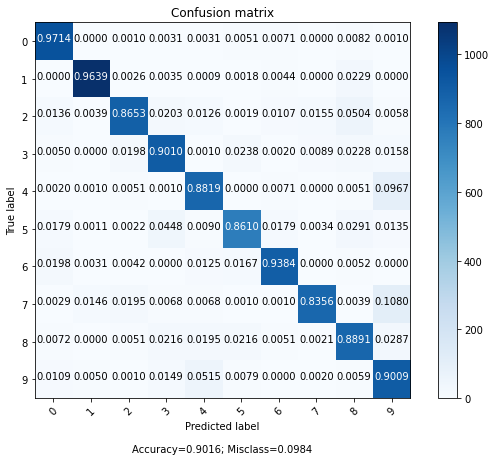

epoch 2 | iter 420 | Avg Loss: 117.28107 (±2.499) | Avg Cls Loss: 0.37675 (±0.122)
epoch 2 | iter 440 | Avg Loss: 116.19006 (±3.392) | Avg Cls Loss: 0.35458 (±0.127)
epoch 2 | iter 460 | Avg Loss: 116.15866 (±2.078) | Avg Cls Loss: 0.31829 (±0.090)
epoch 2 | iter 480 | Avg Loss: 117.17137 (±3.785) | Avg Cls Loss: 0.35076 (±0.118)
epoch 2 | iter 500 | Avg Loss: 117.38776 (±2.829) | Avg Cls Loss: 0.34223 (±0.086)
epoch 2 | iter 520 | Avg Loss: 115.90496 (±3.339) | Avg Cls Loss: 0.31806 (±0.114)
epoch 2 | iter 540 | Avg Loss: 115.34278 (±2.875) | Avg Cls Loss: 0.34371 (±0.087)
epoch 2 | iter 560 | Avg Loss: 115.31117 (±3.049) | Avg Cls Loss: 0.37360 (±0.074)
epoch 2 | iter 580 | Avg Loss: 115.33077 (±2.780) | Avg Cls Loss: 0.34616 (±0.127)
epoch 3 | iter 20 | Avg Loss: 113.65325 (±3.206) | Avg Cls Loss: 0.34502 (±0.120)
epoch 3 | iter 40 | Avg Loss: 115.05050 (±3.383) | Avg Cls Loss: 0.38079 (±0.097)
epoch 3 | iter 60 | Avg Loss: 115.22509 (±3.485) | Avg Cls Loss: 0.34130 (±0.099)
epoch 3

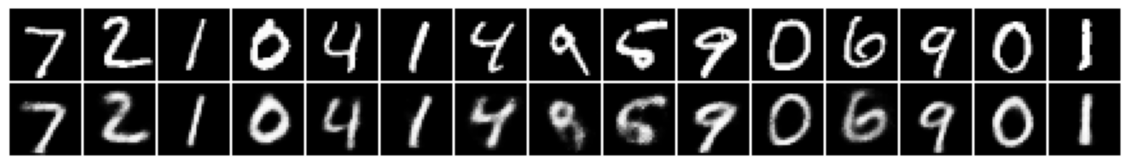

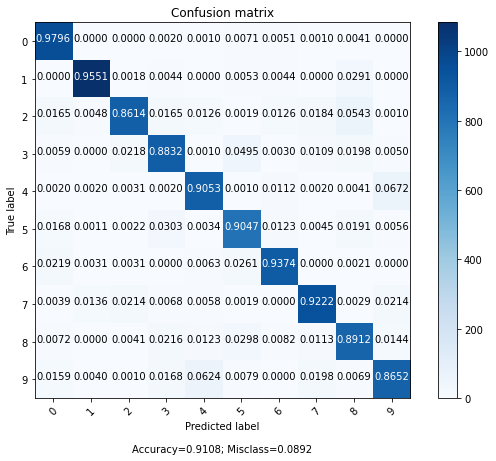

epoch 3 | iter 220 | Avg Loss: 113.97797 (±2.645) | Avg Cls Loss: 0.36126 (±0.107)
epoch 3 | iter 240 | Avg Loss: 113.94570 (±4.033) | Avg Cls Loss: 0.36905 (±0.118)
epoch 3 | iter 260 | Avg Loss: 113.47594 (±2.564) | Avg Cls Loss: 0.39705 (±0.105)
epoch 3 | iter 280 | Avg Loss: 114.50948 (±2.404) | Avg Cls Loss: 0.35538 (±0.115)
epoch 3 | iter 300 | Avg Loss: 112.38837 (±2.952) | Avg Cls Loss: 0.35875 (±0.102)
epoch 3 | iter 320 | Avg Loss: 112.60691 (±1.967) | Avg Cls Loss: 0.40986 (±0.112)
epoch 3 | iter 340 | Avg Loss: 114.27912 (±3.210) | Avg Cls Loss: 0.31779 (±0.111)
epoch 3 | iter 360 | Avg Loss: 112.66166 (±2.521) | Avg Cls Loss: 0.40142 (±0.210)
epoch 3 | iter 400 | Avg Loss: 112.68904 (±2.807) | Avg Cls Loss: 0.36802 (±0.138)


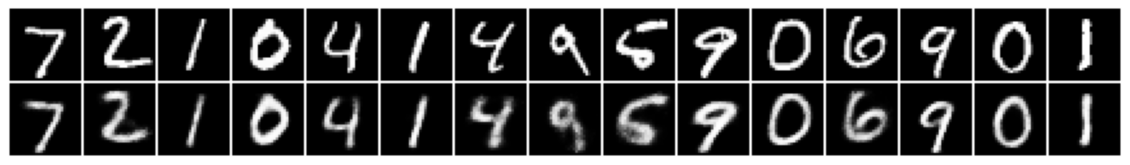

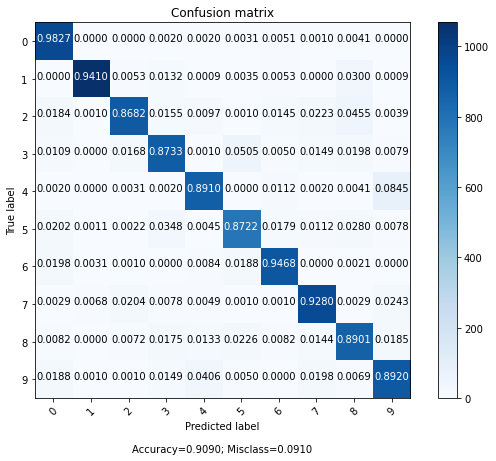

epoch 3 | iter 420 | Avg Loss: 112.24168 (±2.192) | Avg Cls Loss: 0.43382 (±0.137)
epoch 3 | iter 440 | Avg Loss: 113.23111 (±3.401) | Avg Cls Loss: 0.41994 (±0.195)
epoch 3 | iter 460 | Avg Loss: 113.01291 (±3.457) | Avg Cls Loss: 0.38558 (±0.127)
epoch 3 | iter 480 | Avg Loss: 113.16478 (±2.441) | Avg Cls Loss: 0.41226 (±0.188)
epoch 3 | iter 500 | Avg Loss: 110.96109 (±3.352) | Avg Cls Loss: 0.45114 (±0.133)
epoch 3 | iter 520 | Avg Loss: 112.71146 (±2.647) | Avg Cls Loss: 0.48161 (±0.125)
epoch 3 | iter 540 | Avg Loss: 111.65824 (±3.411) | Avg Cls Loss: 0.49414 (±0.210)
epoch 3 | iter 560 | Avg Loss: 112.04058 (±3.907) | Avg Cls Loss: 0.41730 (±0.131)
epoch 3 | iter 580 | Avg Loss: 111.87143 (±2.573) | Avg Cls Loss: 0.48332 (±0.125)
epoch 4 | iter 20 | Avg Loss: 111.78519 (±3.115) | Avg Cls Loss: 0.45619 (±0.167)
epoch 4 | iter 40 | Avg Loss: 111.50228 (±3.075) | Avg Cls Loss: 0.46767 (±0.212)
epoch 4 | iter 60 | Avg Loss: 110.27610 (±2.031) | Avg Cls Loss: 0.46444 (±0.199)
epoch 4

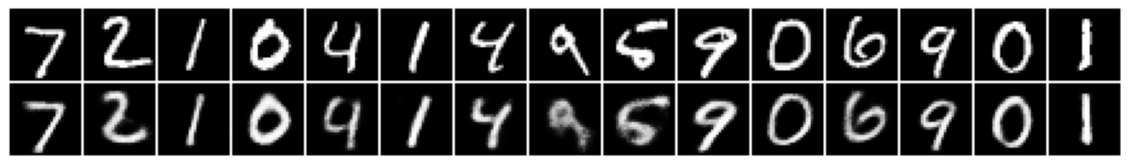

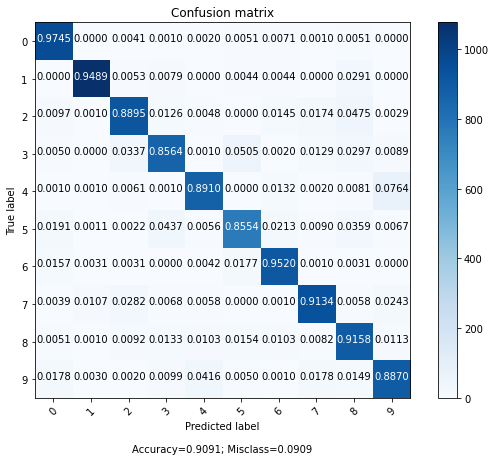

epoch 4 | iter 220 | Avg Loss: 110.63607 (±2.467) | Avg Cls Loss: 0.45009 (±0.202)
epoch 4 | iter 240 | Avg Loss: 110.57159 (±3.342) | Avg Cls Loss: 0.48466 (±0.137)
epoch 4 | iter 260 | Avg Loss: 109.83385 (±3.454) | Avg Cls Loss: 0.49901 (±0.149)
epoch 4 | iter 280 | Avg Loss: 109.42246 (±2.540) | Avg Cls Loss: 0.53670 (±0.226)
epoch 4 | iter 300 | Avg Loss: 109.27619 (±3.277) | Avg Cls Loss: 0.52450 (±0.191)
epoch 4 | iter 320 | Avg Loss: 110.41746 (±2.756) | Avg Cls Loss: 0.42223 (±0.182)
epoch 4 | iter 340 | Avg Loss: 110.67252 (±2.741) | Avg Cls Loss: 0.43769 (±0.137)
epoch 4 | iter 360 | Avg Loss: 109.45278 (±2.880) | Avg Cls Loss: 0.39540 (±0.141)
epoch 4 | iter 400 | Avg Loss: 109.82134 (±3.434) | Avg Cls Loss: 0.51058 (±0.214)


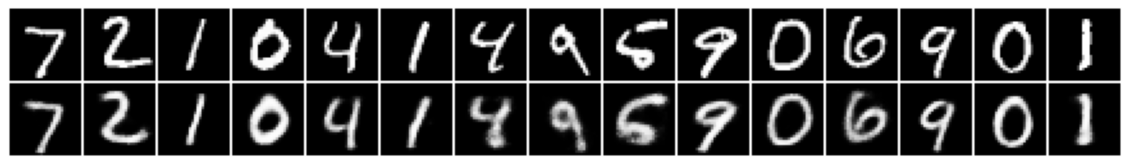

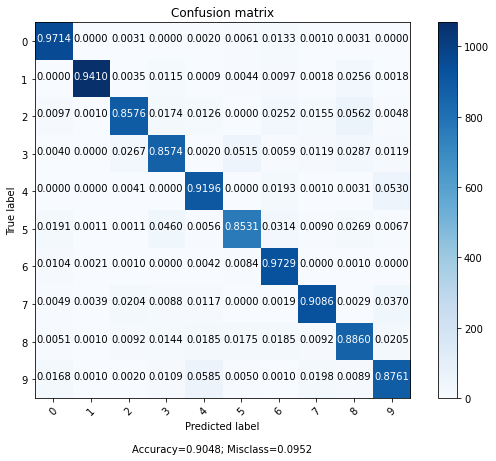

epoch 4 | iter 420 | Avg Loss: 109.41909 (±2.446) | Avg Cls Loss: 0.50014 (±0.199)
epoch 4 | iter 440 | Avg Loss: 110.22716 (±2.846) | Avg Cls Loss: 0.55738 (±0.149)
epoch 4 | iter 460 | Avg Loss: 109.15236 (±2.996) | Avg Cls Loss: 0.55302 (±0.147)
epoch 4 | iter 480 | Avg Loss: 110.34577 (±2.562) | Avg Cls Loss: 0.55415 (±0.207)
epoch 4 | iter 500 | Avg Loss: 109.89217 (±3.049) | Avg Cls Loss: 0.61277 (±0.230)
epoch 4 | iter 520 | Avg Loss: 108.66227 (±2.182) | Avg Cls Loss: 0.49936 (±0.185)
epoch 4 | iter 540 | Avg Loss: 110.25775 (±2.381) | Avg Cls Loss: 0.53580 (±0.223)
epoch 4 | iter 560 | Avg Loss: 110.25562 (±2.658) | Avg Cls Loss: 0.56418 (±0.165)
epoch 4 | iter 580 | Avg Loss: 109.34798 (±2.914) | Avg Cls Loss: 0.61124 (±0.216)
epoch 5 | iter 20 | Avg Loss: 108.49598 (±2.456) | Avg Cls Loss: 0.54373 (±0.189)
epoch 5 | iter 40 | Avg Loss: 110.21642 (±3.355) | Avg Cls Loss: 0.53983 (±0.148)
epoch 5 | iter 60 | Avg Loss: 108.19928 (±2.667) | Avg Cls Loss: 0.47946 (±0.182)
epoch 5

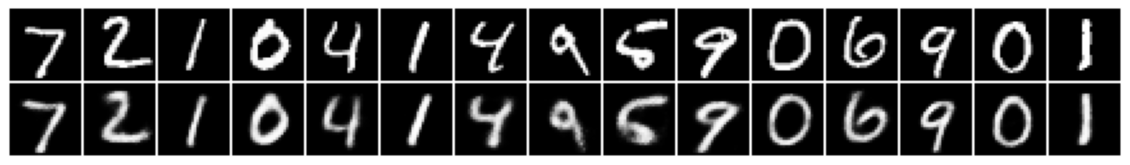

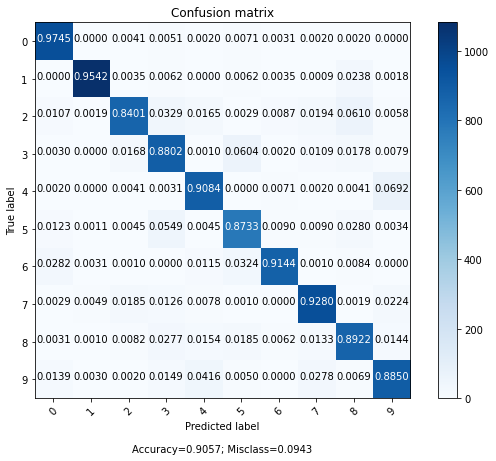

epoch 5 | iter 220 | Avg Loss: 109.05779 (±2.850) | Avg Cls Loss: 0.62445 (±0.237)
epoch 5 | iter 240 | Avg Loss: 108.16897 (±3.089) | Avg Cls Loss: 0.73990 (±0.263)
epoch 5 | iter 260 | Avg Loss: 107.79571 (±3.317) | Avg Cls Loss: 0.52227 (±0.198)
epoch 5 | iter 280 | Avg Loss: 108.54438 (±2.402) | Avg Cls Loss: 0.64204 (±0.232)
epoch 5 | iter 300 | Avg Loss: 108.01376 (±2.644) | Avg Cls Loss: 0.61987 (±0.232)
epoch 5 | iter 320 | Avg Loss: 108.27595 (±2.920) | Avg Cls Loss: 0.61262 (±0.214)
epoch 5 | iter 340 | Avg Loss: 107.93100 (±3.136) | Avg Cls Loss: 0.68101 (±0.223)
epoch 5 | iter 360 | Avg Loss: 107.67787 (±2.827) | Avg Cls Loss: 0.69356 (±0.295)
epoch 5 | iter 400 | Avg Loss: 107.77947 (±3.374) | Avg Cls Loss: 0.66475 (±0.230)


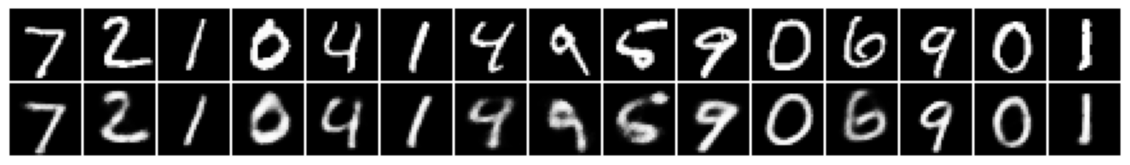

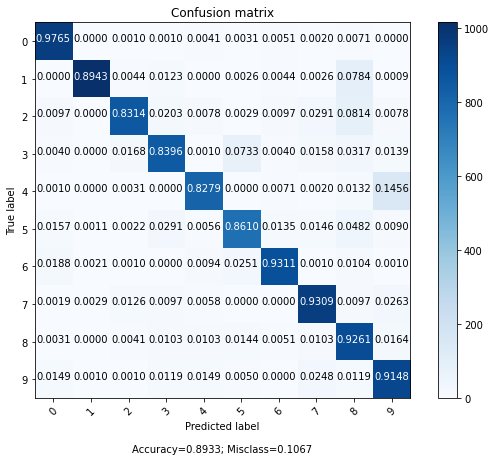

epoch 5 | iter 420 | Avg Loss: 107.62139 (±2.772) | Avg Cls Loss: 0.68204 (±0.221)
epoch 5 | iter 440 | Avg Loss: 107.44813 (±2.900) | Avg Cls Loss: 0.59306 (±0.263)
epoch 5 | iter 460 | Avg Loss: 108.77406 (±3.575) | Avg Cls Loss: 0.57457 (±0.223)
epoch 5 | iter 480 | Avg Loss: 106.75775 (±2.207) | Avg Cls Loss: 0.65729 (±0.228)
epoch 5 | iter 500 | Avg Loss: 107.53160 (±3.387) | Avg Cls Loss: 0.61188 (±0.239)
epoch 5 | iter 520 | Avg Loss: 108.55471 (±2.582) | Avg Cls Loss: 0.70226 (±0.219)
epoch 5 | iter 540 | Avg Loss: 107.16530 (±3.364) | Avg Cls Loss: 0.74678 (±0.234)
epoch 5 | iter 560 | Avg Loss: 106.67478 (±1.448) | Avg Cls Loss: 0.68444 (±0.358)
epoch 5 | iter 580 | Avg Loss: 108.05831 (±3.151) | Avg Cls Loss: 0.71922 (±0.232)
epoch 6 | iter 20 | Avg Loss: 107.90851 (±3.033) | Avg Cls Loss: 0.72209 (±0.299)
epoch 6 | iter 40 | Avg Loss: 105.98577 (±3.536) | Avg Cls Loss: 0.70710 (±0.210)
epoch 6 | iter 60 | Avg Loss: 107.45697 (±3.349) | Avg Cls Loss: 0.60543 (±0.200)
epoch 6

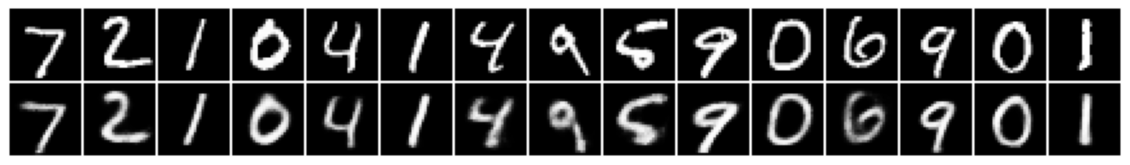

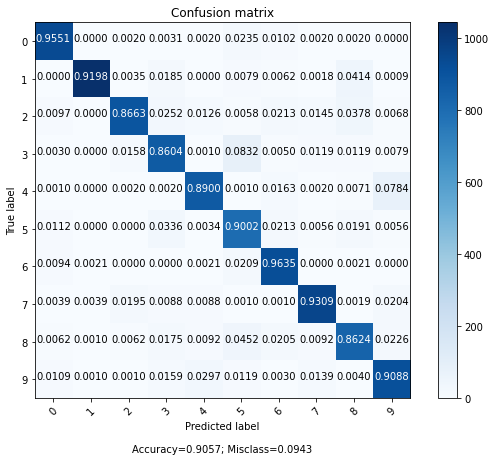

epoch 6 | iter 220 | Avg Loss: 108.53717 (±2.342) | Avg Cls Loss: 0.74433 (±0.296)
epoch 6 | iter 240 | Avg Loss: 108.92691 (±3.202) | Avg Cls Loss: 0.91537 (±0.309)
epoch 6 | iter 260 | Avg Loss: 105.67104 (±2.613) | Avg Cls Loss: 0.70866 (±0.326)
epoch 6 | iter 280 | Avg Loss: 107.10754 (±2.442) | Avg Cls Loss: 0.79307 (±0.233)
epoch 6 | iter 300 | Avg Loss: 105.84158 (±2.747) | Avg Cls Loss: 0.67734 (±0.261)
epoch 6 | iter 320 | Avg Loss: 107.00167 (±2.203) | Avg Cls Loss: 0.70466 (±0.288)
epoch 6 | iter 340 | Avg Loss: 106.32541 (±2.773) | Avg Cls Loss: 0.78483 (±0.259)
epoch 6 | iter 360 | Avg Loss: 106.75164 (±1.906) | Avg Cls Loss: 0.77483 (±0.245)
epoch 6 | iter 400 | Avg Loss: 106.73660 (±2.313) | Avg Cls Loss: 0.72268 (±0.244)


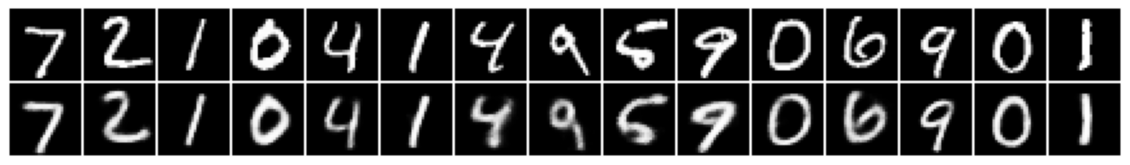

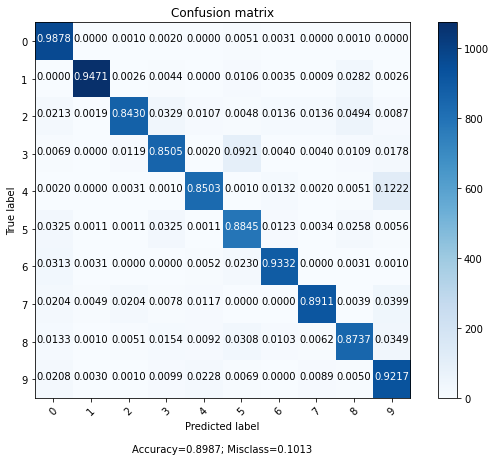

epoch 6 | iter 420 | Avg Loss: 107.07498 (±2.664) | Avg Cls Loss: 0.66160 (±0.240)
epoch 6 | iter 440 | Avg Loss: 106.89742 (±2.533) | Avg Cls Loss: 0.70893 (±0.291)
epoch 6 | iter 460 | Avg Loss: 105.27368 (±2.132) | Avg Cls Loss: 0.70710 (±0.309)
epoch 6 | iter 480 | Avg Loss: 107.37483 (±2.351) | Avg Cls Loss: 0.73405 (±0.337)
epoch 6 | iter 500 | Avg Loss: 106.87625 (±2.650) | Avg Cls Loss: 0.93761 (±0.316)
epoch 6 | iter 520 | Avg Loss: 105.79763 (±2.655) | Avg Cls Loss: 0.77478 (±0.223)
epoch 6 | iter 540 | Avg Loss: 106.54026 (±2.710) | Avg Cls Loss: 0.80954 (±0.206)
epoch 6 | iter 560 | Avg Loss: 106.70928 (±2.274) | Avg Cls Loss: 0.80493 (±0.288)
epoch 6 | iter 580 | Avg Loss: 107.24514 (±2.831) | Avg Cls Loss: 0.85707 (±0.319)
epoch 7 | iter 20 | Avg Loss: 106.04630 (±3.379) | Avg Cls Loss: 0.87199 (±0.289)
epoch 7 | iter 40 | Avg Loss: 107.05223 (±3.084) | Avg Cls Loss: 0.79111 (±0.367)
epoch 7 | iter 60 | Avg Loss: 106.57791 (±3.240) | Avg Cls Loss: 0.91513 (±0.299)
epoch 7

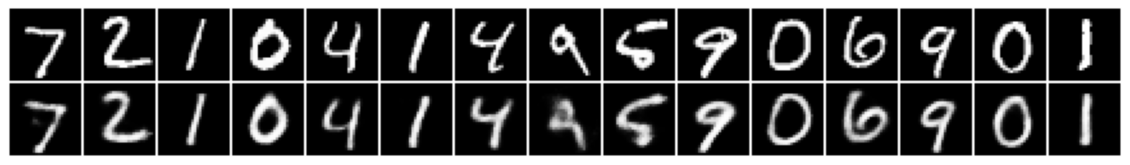

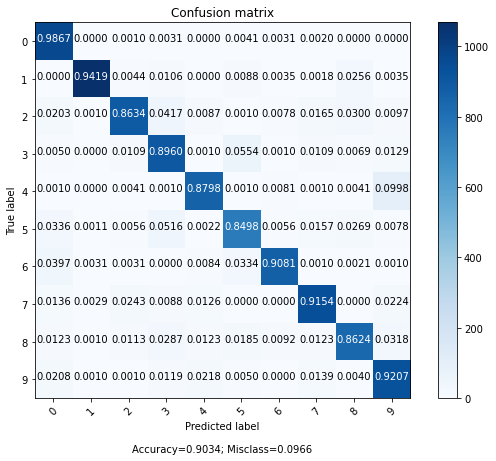

epoch 7 | iter 220 | Avg Loss: 105.73961 (±2.579) | Avg Cls Loss: 0.78227 (±0.292)
epoch 7 | iter 240 | Avg Loss: 105.87578 (±1.853) | Avg Cls Loss: 0.73969 (±0.267)
epoch 7 | iter 260 | Avg Loss: 105.33430 (±2.534) | Avg Cls Loss: 0.76941 (±0.353)
epoch 7 | iter 280 | Avg Loss: 106.83682 (±2.647) | Avg Cls Loss: 0.81389 (±0.347)
epoch 7 | iter 300 | Avg Loss: 105.72376 (±2.783) | Avg Cls Loss: 0.87515 (±0.390)
epoch 7 | iter 320 | Avg Loss: 106.07532 (±3.156) | Avg Cls Loss: 0.89664 (±0.391)
epoch 7 | iter 340 | Avg Loss: 104.68706 (±2.940) | Avg Cls Loss: 0.65954 (±0.225)
epoch 7 | iter 360 | Avg Loss: 105.63203 (±2.767) | Avg Cls Loss: 0.81974 (±0.390)
epoch 7 | iter 400 | Avg Loss: 105.40626 (±2.460) | Avg Cls Loss: 0.83507 (±0.309)


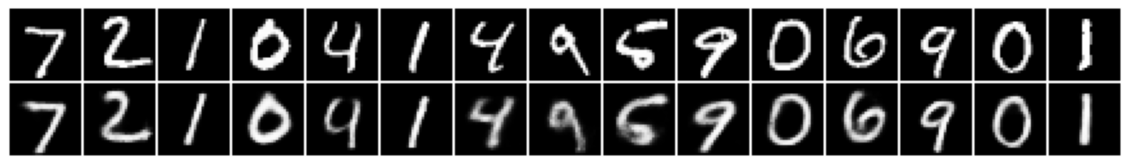

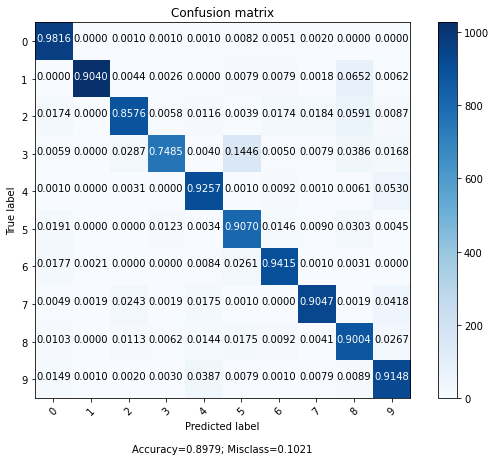

epoch 7 | iter 420 | Avg Loss: 104.99514 (±3.096) | Avg Cls Loss: 0.87672 (±0.277)
epoch 7 | iter 440 | Avg Loss: 104.96759 (±3.411) | Avg Cls Loss: 0.77762 (±0.190)
epoch 7 | iter 460 | Avg Loss: 104.93324 (±1.854) | Avg Cls Loss: 0.73472 (±0.235)
epoch 7 | iter 480 | Avg Loss: 106.54246 (±2.414) | Avg Cls Loss: 0.83883 (±0.259)
epoch 7 | iter 500 | Avg Loss: 106.07847 (±2.690) | Avg Cls Loss: 0.79621 (±0.314)
epoch 7 | iter 520 | Avg Loss: 105.04645 (±2.309) | Avg Cls Loss: 0.89982 (±0.380)
epoch 7 | iter 540 | Avg Loss: 105.11504 (±2.565) | Avg Cls Loss: 0.96003 (±0.324)
epoch 7 | iter 560 | Avg Loss: 105.68177 (±2.855) | Avg Cls Loss: 0.94114 (±0.278)
epoch 7 | iter 580 | Avg Loss: 105.68681 (±2.766) | Avg Cls Loss: 0.91259 (±0.334)
epoch 8 | iter 20 | Avg Loss: 105.43061 (±2.975) | Avg Cls Loss: 0.96348 (±0.385)
epoch 8 | iter 40 | Avg Loss: 105.44167 (±3.210) | Avg Cls Loss: 0.75354 (±0.247)
epoch 8 | iter 60 | Avg Loss: 104.30799 (±3.497) | Avg Cls Loss: 0.90015 (±0.363)
epoch 8

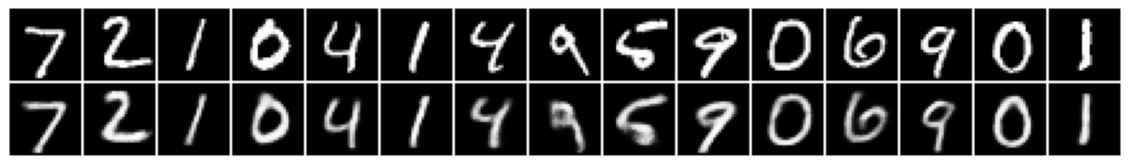

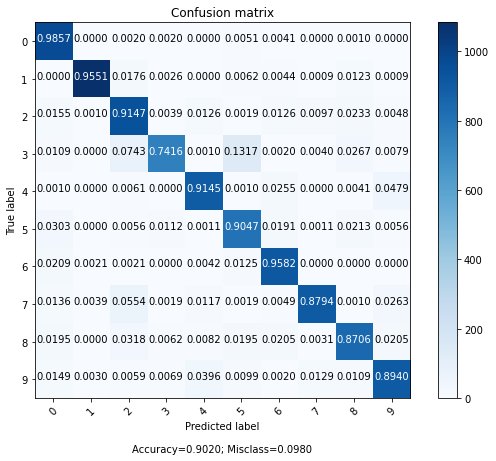

epoch 8 | iter 220 | Avg Loss: 105.20144 (±2.989) | Avg Cls Loss: 0.90915 (±0.336)
epoch 8 | iter 240 | Avg Loss: 105.67434 (±2.761) | Avg Cls Loss: 0.84867 (±0.346)
epoch 8 | iter 260 | Avg Loss: 104.85023 (±3.080) | Avg Cls Loss: 0.71331 (±0.314)
epoch 8 | iter 280 | Avg Loss: 105.02430 (±2.435) | Avg Cls Loss: 0.89881 (±0.517)
epoch 8 | iter 300 | Avg Loss: 105.16326 (±2.001) | Avg Cls Loss: 0.90827 (±0.234)
epoch 8 | iter 320 | Avg Loss: 104.43991 (±3.165) | Avg Cls Loss: 0.81870 (±0.326)
epoch 8 | iter 340 | Avg Loss: 105.87823 (±2.262) | Avg Cls Loss: 0.76603 (±0.280)
epoch 8 | iter 360 | Avg Loss: 104.95242 (±2.498) | Avg Cls Loss: 0.89255 (±0.279)
epoch 8 | iter 400 | Avg Loss: 104.88211 (±3.044) | Avg Cls Loss: 0.90165 (±0.351)


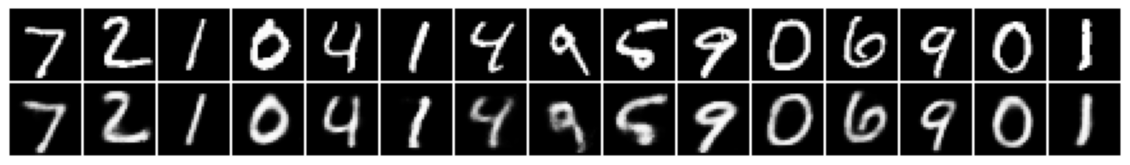

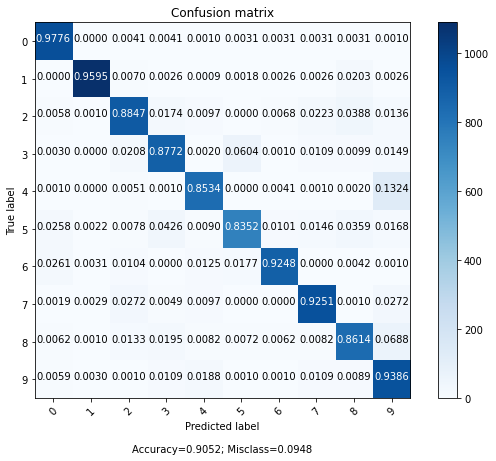

epoch 8 | iter 420 | Avg Loss: 103.21337 (±3.388) | Avg Cls Loss: 0.86404 (±0.375)
epoch 8 | iter 440 | Avg Loss: 105.00163 (±2.524) | Avg Cls Loss: 1.09898 (±0.352)
epoch 8 | iter 460 | Avg Loss: 104.21837 (±3.082) | Avg Cls Loss: 1.17934 (±0.380)
epoch 8 | iter 480 | Avg Loss: 104.14870 (±2.111) | Avg Cls Loss: 1.04669 (±0.285)
epoch 8 | iter 500 | Avg Loss: 104.65684 (±2.447) | Avg Cls Loss: 0.95055 (±0.418)
epoch 8 | iter 520 | Avg Loss: 104.54012 (±2.014) | Avg Cls Loss: 1.06606 (±0.378)
epoch 8 | iter 540 | Avg Loss: 104.35276 (±2.831) | Avg Cls Loss: 0.90629 (±0.258)
epoch 8 | iter 560 | Avg Loss: 104.63684 (±2.637) | Avg Cls Loss: 1.10773 (±0.358)
epoch 8 | iter 580 | Avg Loss: 104.60159 (±2.437) | Avg Cls Loss: 0.80206 (±0.352)
epoch 9 | iter 20 | Avg Loss: 103.57026 (±2.713) | Avg Cls Loss: 0.86895 (±0.321)
epoch 9 | iter 40 | Avg Loss: 103.37958 (±2.692) | Avg Cls Loss: 0.91595 (±0.305)
epoch 9 | iter 60 | Avg Loss: 103.60329 (±2.472) | Avg Cls Loss: 0.98995 (±0.348)
epoch 9

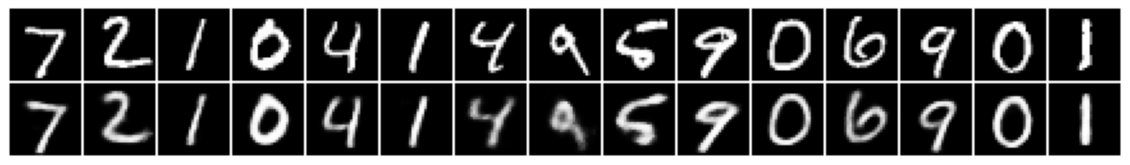

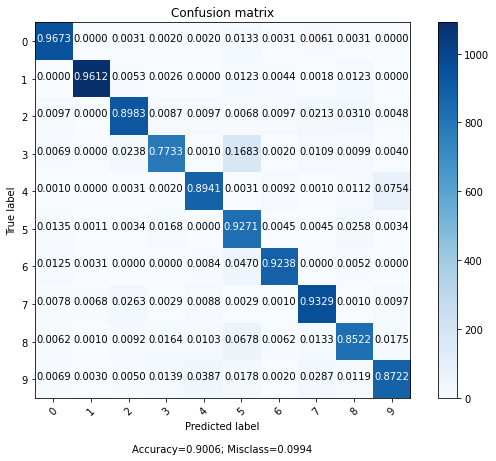

epoch 9 | iter 220 | Avg Loss: 104.32874 (±2.874) | Avg Cls Loss: 0.94547 (±0.385)
epoch 9 | iter 240 | Avg Loss: 104.01339 (±3.862) | Avg Cls Loss: 1.13637 (±0.427)
epoch 9 | iter 260 | Avg Loss: 104.59731 (±3.204) | Avg Cls Loss: 1.09835 (±0.432)
epoch 9 | iter 280 | Avg Loss: 103.66231 (±1.932) | Avg Cls Loss: 1.01019 (±0.506)
epoch 9 | iter 300 | Avg Loss: 104.98606 (±2.665) | Avg Cls Loss: 1.03157 (±0.424)
epoch 9 | iter 320 | Avg Loss: 103.90289 (±2.875) | Avg Cls Loss: 1.03677 (±0.320)
epoch 9 | iter 340 | Avg Loss: 104.08456 (±2.926) | Avg Cls Loss: 1.07272 (±0.350)
epoch 9 | iter 360 | Avg Loss: 104.28672 (±1.976) | Avg Cls Loss: 1.00151 (±0.367)
epoch 9 | iter 400 | Avg Loss: 105.08887 (±3.144) | Avg Cls Loss: 1.17136 (±0.454)


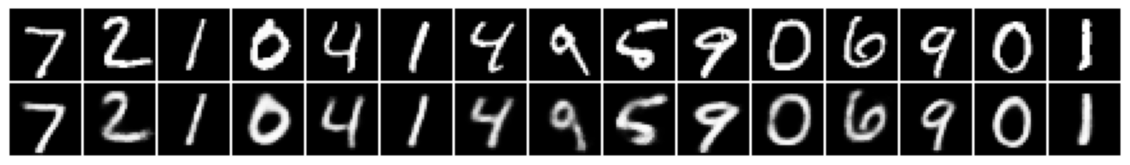

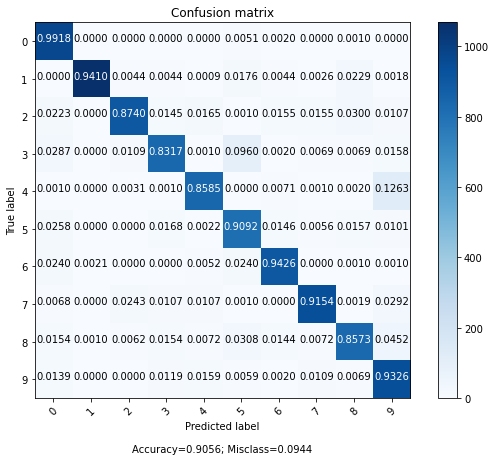

epoch 9 | iter 420 | Avg Loss: 103.68226 (±2.814) | Avg Cls Loss: 0.94332 (±0.326)
epoch 9 | iter 440 | Avg Loss: 103.35484 (±3.035) | Avg Cls Loss: 0.96657 (±0.464)
epoch 9 | iter 460 | Avg Loss: 104.19591 (±2.142) | Avg Cls Loss: 0.98755 (±0.331)
epoch 9 | iter 480 | Avg Loss: 102.91436 (±2.141) | Avg Cls Loss: 0.92430 (±0.391)
epoch 9 | iter 500 | Avg Loss: 105.23453 (±2.786) | Avg Cls Loss: 0.79749 (±0.302)
epoch 9 | iter 520 | Avg Loss: 103.45464 (±2.331) | Avg Cls Loss: 0.89248 (±0.370)
epoch 9 | iter 540 | Avg Loss: 104.42897 (±2.332) | Avg Cls Loss: 1.03863 (±0.394)
epoch 9 | iter 560 | Avg Loss: 103.99657 (±2.634) | Avg Cls Loss: 0.86112 (±0.376)
epoch 9 | iter 580 | Avg Loss: 103.27706 (±2.782) | Avg Cls Loss: 0.86443 (±0.279)
epoch 10 | iter 20 | Avg Loss: 103.44189 (±2.606) | Avg Cls Loss: 0.79564 (±0.377)
epoch 10 | iter 40 | Avg Loss: 104.70497 (±3.164) | Avg Cls Loss: 0.93784 (±0.434)
epoch 10 | iter 60 | Avg Loss: 103.58856 (±1.586) | Avg Cls Loss: 0.96504 (±0.409)
epoc

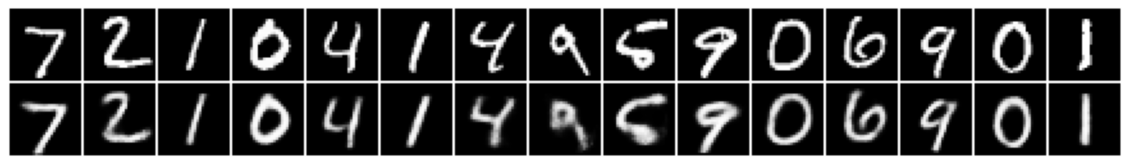

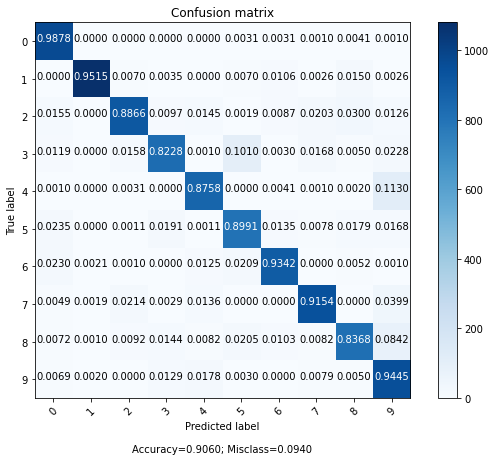

epoch 10 | iter 220 | Avg Loss: 103.32742 (±2.754) | Avg Cls Loss: 1.31339 (±0.357)
epoch 10 | iter 240 | Avg Loss: 103.16204 (±2.248) | Avg Cls Loss: 0.94368 (±0.377)
epoch 10 | iter 260 | Avg Loss: 103.90540 (±2.632) | Avg Cls Loss: 0.83846 (±0.336)
epoch 10 | iter 280 | Avg Loss: 103.01220 (±2.506) | Avg Cls Loss: 1.00150 (±0.524)
epoch 10 | iter 300 | Avg Loss: 103.72808 (±3.150) | Avg Cls Loss: 0.85898 (±0.335)
epoch 10 | iter 320 | Avg Loss: 102.43943 (±1.763) | Avg Cls Loss: 1.08575 (±0.370)
epoch 10 | iter 340 | Avg Loss: 103.16201 (±2.180) | Avg Cls Loss: 0.99415 (±0.518)
epoch 10 | iter 360 | Avg Loss: 103.44683 (±2.834) | Avg Cls Loss: 1.32584 (±0.478)
epoch 10 | iter 400 | Avg Loss: 103.08158 (±2.875) | Avg Cls Loss: 1.05776 (±0.479)


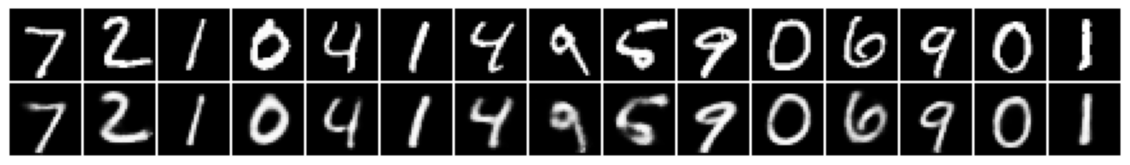

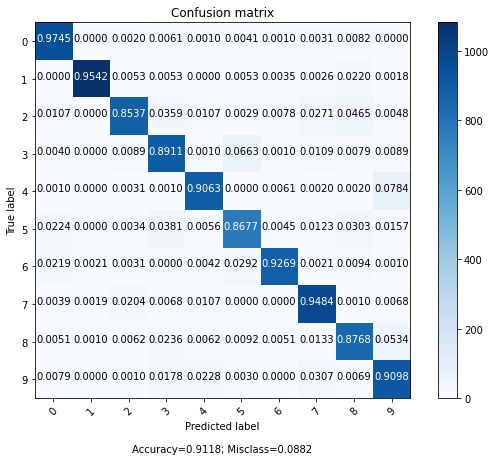

epoch 10 | iter 420 | Avg Loss: 104.82967 (±1.906) | Avg Cls Loss: 0.93832 (±0.319)
epoch 10 | iter 440 | Avg Loss: 102.79824 (±2.022) | Avg Cls Loss: 1.01380 (±0.436)
epoch 10 | iter 460 | Avg Loss: 103.42933 (±3.198) | Avg Cls Loss: 1.18437 (±0.447)
epoch 10 | iter 480 | Avg Loss: 103.56811 (±2.977) | Avg Cls Loss: 0.94841 (±0.421)
epoch 10 | iter 500 | Avg Loss: 103.69269 (±3.009) | Avg Cls Loss: 1.05502 (±0.555)
epoch 10 | iter 520 | Avg Loss: 103.63635 (±2.813) | Avg Cls Loss: 1.22940 (±0.399)
epoch 10 | iter 540 | Avg Loss: 103.88576 (±2.599) | Avg Cls Loss: 0.98567 (±0.418)
epoch 10 | iter 560 | Avg Loss: 103.82699 (±2.554) | Avg Cls Loss: 1.01834 (±0.416)
epoch 10 | iter 580 | Avg Loss: 103.09046 (±2.677) | Avg Cls Loss: 1.14692 (±0.514)


In [0]:
loss_logger = MetricLogger("Loss")
cls_loss_logger = MetricLogger("Cls Loss")
acc_logger = MetricLogger('Accuracy')

train_vae(train_dl, train_dl_u, valid_dl, vae, 10, loss_logger, cls_loss_logger, acc_logger, semi_sup_epochs=1)

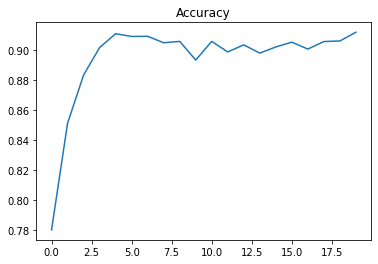

In [0]:
acc_logger.plot()

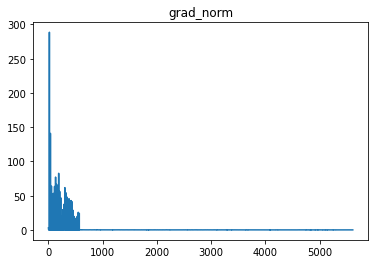

In [0]:
# we can see that classifier learns fast during semi-supervised setting (high gradient signal) and much slower afterrwards (signal is small, yet nonzero).

grad_norm.plot()